In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

## 함수
텐서플로우 함수는 파이토치(PyTorch), 데아노(theano) 등의 딥러닝 라이브러리에 있는 함수 기능을 본따 텐서플로우 버전 2에서 새로 만들어진 방법이다. 

함수를 사용하면 **텐서플로우 버전 1에서처럼 플레이스홀더(placeholder)와 계산 그래프 등을 명시적으로 사용하지 않고** 선언적으로 계산 과정을 구현할 수 있다.

텐서플로우 함수는 일반 파이썬 함수에 **@tf.function** 데코레이터를 적용하여 구현한다.

In [2]:
@tf.function
def f(a, b):
  return tf.matmul(a, b)

f

In [3]:
a = tf.constant([[3, 4]], dtype=tf.float32)  # 3 x 1 + 4 x 2 = 3 + 8 = 11
b = tf.constant([[1], [2]], dtype=tf.float32) 
c = f(a, b)
c.numpy()

array([[11.]], dtype=float32)

## 변수형 텐서

변수형 텐서는 텐서의 값이 바뀔 수 있다. **Variable** 클래스로 정의하며 항상 초기값을 지정해 주어야 한다. 자료형과 크기는 초기값으로부터 자동으로 유추한다.

In [6]:
# 실수 변수형 텐서
s = tf.Variable(1.0)
s.numpy()

1.0

In [7]:
# 벡터 변수형 텐서
v = tf.Variable(tf.ones(2,))
v.numpy()

array([1., 1.], dtype=float32)

In [8]:
# 행렬 변수형 텐서
x = tf.Variable(tf.ones((2, 1)))
x.numpy()

array([[1.],
       [1.]], dtype=float32)

변수 텐서의 값을 바꿀 때는 **assign, assign_add, assign_sub** 메서드를 사용한다.

* **assign**: 값을 완전히 할당. **=**에 해당
* **assign_add**: 값을 증가. **+=**에 해당
* **assign_sub**: 값을 감소. **-=**에 해당


In [9]:
# 다음과 같이 하면 안된다!. 이렇게 하면 변수형 텐서가 상수형 텐서로 변한다!
# x = b

x.assign(b)
x.numpy()

array([[1.],
       [2.]], dtype=float32)

In [10]:
x.assign_add(b)
x.numpy()

array([[2.],
       [4.]], dtype=float32)

In [11]:
x.assign_sub(b)
x.numpy()

array([[1.],
       [2.]], dtype=float32)

## 미분

변수 텐서 혹은 변수 텐서를 포함하는 연산의 결과로 만들어진 텐서를 입력으로 가지는 함수는 그 변수 텐서로 미분한 값을 계산할 수 있다.

1. **tf.GradientTape()**로 만들어지는 gradient tape 컨텍스트 내에서 함수값 결과를 저장한 텐서 y를 만든다.

2. **tape.gradient(y, x)** 명령으로 변수형 텐서 x에 대한 y의 미분값 계산

In [12]:
with tf.GradientTape() as tape:
  # x가 변수 텐서
  y = f(a, x)
  
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

array([[3.],
       [4.]], dtype=float32)

이 때 미분하는 텐서가 상수형이면 결과로는 None이 출력된다.

In [13]:
with tf.GradientTape() as tape:
  y = f(a, x)

dy_da = tape.gradient(y, a)
dy_da.numpy()

AttributeError: ignored

In [14]:
dy_da is None

True

만약 상수형 텐서에 대해 미분하고 싶으면 watch 명령을 사용하여 변수형처럼 바꾸어준다.

In [15]:
# 상수형 텐서 미분 -> watch 명령으로 변수로 바꿈
with tf.GradientTape() as tape:
  tape.watch(a)
  y = f(a, x)
  
dy_da = tape.gradient(y, a)
dy_da.numpy()

array([[1., 2.]], dtype=float32)

## 선형회귀 모형
1. 우선 데이터를 만든다.

In [16]:
# 정답인 가중치 벡터
w0 = tf.constant([[3.0], [5.0]])

# 입력 데이터 행렬
X = tf.concat([tf.ones((10, 1)), tf.random.normal((10, 1))], axis=1)

# 타겟 벡터
y_target = tf.matmul(X, w0) + tf.random.normal((10, 1))
y_target.numpy()

array([[ 5.3011875],
       [ 2.8787298],
       [-8.359911 ],
       [-0.7698867],
       [-3.8510222],
       [ 4.077081 ],
       [ 7.825036 ],
       [-3.742842 ],
       [ 5.5474973],
       [ 6.6323133]], dtype=float32)

In [17]:
X.numpy()

array([[ 1.        ,  0.07644117],
       [ 1.        ,  0.35982522],
       [ 1.        , -2.5231104 ],
       [ 1.        , -0.64422894],
       [ 1.        , -1.6070409 ],
       [ 1.        ,  0.24642615],
       [ 1.        ,  1.1151459 ],
       [ 1.        , -1.189524  ],
       [ 1.        ,  0.4468818 ],
       [ 1.        ,  0.4905986 ]], dtype=float32)

2. 손실함수를 정의하고 w의 초기값에 대해 손실함수 값을 구해본다.

In [20]:
# 손실함수 정의
@tf.function
def loss(y_predict, y_target):
  return tf.reduce_sum(tf.square(y_target - y_predict))

# 변수형으로 정의한 가중치 벡터(초기값 영벡터)
w = tf.Variable([[0.0], [0.0]])

# 예측치 : 변수형 입력을 가진다
y_predict = tf.matmul(X, w)

loss(y_predict, y_target).numpy()

288.32584

**loss_value**를 계산하는 입력 중에 변수형 w 가 있으므로 **loss_value**는 w로 미분할 수 있다. **미분연산으로 그레디언트를 구한다.**

In [21]:
def gradient(w):
  with tf.GradientTape() as tape:
    y_predict = tf.matmul(X, w)
    loss_value = loss(y_predict, y_target)
    
    # loss value를 계산하는 입력 중에 변수형 w가 있으므로 미분 가능
    g = tape.gradient(loss_value, w)
    return g
  
g = gradient(w)
g.numpy()

array([[-31.076366],
       [-98.26924 ]], dtype=float32)

steepest gradient descent 방법에 따라 가중치를 업데이트 한다.

$$w_{k+1} = w_k - \mu \cdot g$$

In [22]:
mu = 0.01
w.assign_sub(mu * g)
w.numpy()

array([[0.31076366],
       [0.9826924 ]], dtype=float32)

업데이트한 가중치로 다시 손실함수값을 구하면 감소한다.

In [24]:
y_predict = tf.matmul(X, w)
loss(y_predict, y_target).numpy()

193.31808

이 과정을 반복한다.

In [26]:
loss_values = []
w_0s = []
w_1s = []

for i in range(30):
  # 그레디언트 계산
  g = gradient(w)
  
  # 가중치 업데이트
  w.assign_sub(mu * g)
  
  # 손실함수 계산
  y_predict = tf.matmul(X, w)
  loss_value = loss(y_predict, y_target).numpy()
  loss_values.append(loss_value)
  
  # 가중치 저장
  w_0 = w.numpy()[0][0]
  w_1 = w.numpy()[1][0]
  w_0s.append(w_0)
  w_1s.append(w_1)
  
  print(f"[{i:02d}] loss: {loss_value: 7.3f}, w_0: {w_0: 3.2f}, w_1: {w_1: 3.2f}")
 

[00] loss:  133.383, w_0:  0.62, w_1:  1.74
[01] loss:  94.539, w_0:  0.92, w_1:  2.32
[02] loss:  68.786, w_0:  1.20, w_1:  2.77
[03] loss:  51.399, w_0:  1.45, w_1:  3.13
[04] loss:  39.493, w_0:  1.67, w_1:  3.42
[05] loss:  31.254, w_0:  1.87, w_1:  3.64
[06] loss:  25.508, w_0:  2.04, w_1:  3.82
[07] loss:  21.477, w_0:  2.19, w_1:  3.97
[08] loss:  18.639, w_0:  2.32, w_1:  4.09
[09] loss:  16.634, w_0:  2.43, w_1:  4.19
[10] loss:  15.216, w_0:  2.53, w_1:  4.27
[11] loss:  14.210, w_0:  2.61, w_1:  4.33
[12] loss:  13.497, w_0:  2.68, w_1:  4.39
[13] loss:  12.990, w_0:  2.73, w_1:  4.43
[14] loss:  12.631, w_0:  2.78, w_1:  4.47
[15] loss:  12.375, w_0:  2.83, w_1:  4.50
[16] loss:  12.194, w_0:  2.86, w_1:  4.53
[17] loss:  12.064, w_0:  2.89, w_1:  4.55
[18] loss:  11.973, w_0:  2.92, w_1:  4.57
[19] loss:  11.907, w_0:  2.94, w_1:  4.58
[20] loss:  11.861, w_0:  2.96, w_1:  4.59
[21] loss:  11.828, w_0:  2.97, w_1:  4.60
[22] loss:  11.805, w_0:  2.99, w_1:  4.61
[23] loss:

In [0]:
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

plt.rc('font', family=font_name)

fm._rebuild()

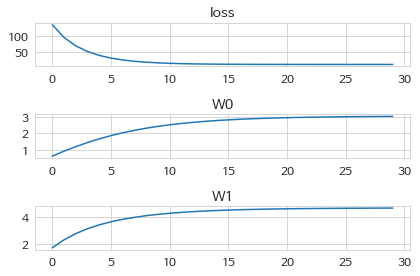

In [28]:
plt.subplot(311)
plt.plot(loss_values)
plt.title("loss")
plt.subplot(312)
plt.plot(w_0s)
plt.title("W0")
plt.subplot(313)
plt.plot(w_1s)
plt.title("W1")
plt.tight_layout()
plt.show()

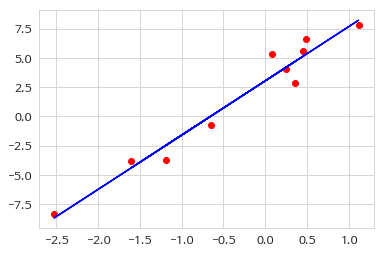

In [31]:
plt.plot(X[:, 1], y_target, 'ro')
plt.plot(X[:, 1], y_predict, 'b-')
plt.show()

In [0]:
X.numpy()

array([[ 1.        ,  1.5110626 ],
       [ 1.        ,  0.42292204],
       [ 1.        , -0.41969493],
       [ 1.        , -1.0360372 ],
       [ 1.        , -1.2368279 ],
       [ 1.        ,  0.47027302],
       [ 1.        , -0.01397489],
       [ 1.        ,  1.1888583 ],
       [ 1.        ,  0.60253334],
       [ 1.        ,  0.5997111 ]], dtype=float32)

In [0]:
y_target.numpy()

array([[11.622193 ],
       [ 5.3091593],
       [ 0.3706963],
       [-2.0882854],
       [-3.3616762],
       [ 4.4320564],
       [ 0.8523698],
       [10.983481 ],
       [ 6.8155665],
       [ 5.0676517]], dtype=float32)

In [0]:
y_predict.numpy()

array([[11.242675 ],
       [ 5.19396  ],
       [ 0.5100534],
       [-2.9160464],
       [-4.032194 ],
       [ 5.457173 ],
       [ 2.7653544],
       [ 9.451617 ],
       [ 6.1923766],
       [ 6.176688 ]], dtype=float32)